In [1]:
# !git clone https://github.com/AxelThevenot/Python_Benchmark_Test_Optimization_Function_Single_Objective.git
# !mv Python_Benchmark_Test_Optimization_Function_Single_Objective/src .
# !mv Python_Benchmark_Test_Optimization_Function_Single_Objective/pybenchfunction/ .
# !ls Python_Benchmark_Test_Optimization_Function_Single_Objective/

In [2]:
import torch
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pybenchfunction as bench
%matplotlib inline

In [3]:
# Functions with sum of terms structure

def LevyN13_i(i,x):
    w = 1.0+(x-1.0)/4.0
    if i==0:
        return  torch.sin(torch.pi*w[0])**2
    else:
        return  ( (w[i-1]-1)**2*(1+10*torch.sin(torch.pi*w[i-1]+1)**2)+ (w[-1]-1)**2*(1+torch.sin(2*torch.pi*w[-1])**2)         )

def PermDBeta_i(i,x):
    beta=0.5  # Added default value for beta
    v = 0
    # j = np.arange(1, d+1)
    # j = range(1,d+1)
    # v = torch.sum(((j**(i+1) + beta) *((x/j)**(i+1) - 1))**2 ) 
    for j in range(d):
        # v+=(1+j+beta)*(x[j]**(i+1) -1. / (j+1)**(i+1))   
        # v+=(1+j+beta)*(x[j]/(j+1)**(i+1))  
        v+= (((j+1)**(i+1) + beta) *((x[j]/(j+1))**(i+1) - 1))**2 
    return v
    
def Rastrigin_i(i,x):
    v = 10+x[i]**2-10*torch.cos(2*torch.pi*x[i])
    return v
    
def RosenBrock_i(i,x):
    b = 100
    a = 1
    return b * (x[i] - x[i - 1] ** 2) ** 2 + (a - x[i]) ** 2   


In [4]:
from algorithms import *

In [5]:
font = {'size'   : 12}
import matplotlib
matplotlib.rc('font', **font)

def plot_level_set_results(bench_function, x_lists):
    labels = ['SP2plus', 'SP2', 'SGD',  "SP", 'Adam', 'Newton']
    colors = ['g', 'b', 'y', 'r', 'tab:pink', 'm' ]
    markers = ["x", "o", "2" , "P", ",", "v"]
    # bench.plot_3d(thevenot, n_space=100, ax=None,show=False)
    bench.plot_2d(bench_function, n_space=100, ax=None, show=False)
    X_domain, Y_domain = bench_function.input_domain
    X_min, minimum = bench_function.get_global_minimum(2)
    plt.plot(X_min[0],X_min[1],'*', markersize=10, color='yellow')
    for x_list, color, marker, label in zip(x_lists, colors, markers, labels):
        plt.scatter(x_list[0],x_list[1], s=20, label = label, zorder=1, color = color, marker=marker)
    plt.xlim(X_domain)
    plt.ylim(Y_domain) 
    plt.tight_layout()
    plt.legend()
    plt.savefig(bench_function.name + '-2d.pdf', bbox_inches='tight', pad_inches =0)
    plt.show()


    bench.plot_3d(bench_function, n_space=100, ax=None, show=False)
    plt.plot(X_min[0],X_min[1],'*', markersize=12, color='yellow')
    
    for x_list, color, marker, label in zip(x_lists, colors, markers, labels):
        plt.scatter(x_list[0],x_list[1], s=20, label = label, zorder=1, color = color, marker=marker)
    plt.xlim(X_domain)
    plt.ylim(Y_domain) 
    plt.tight_layout()
    plt.savefig(bench_function.name + '-3d.pdf', bbox_inches='tight', pad_inches =0)
    plt.legend() 
    plt.show()


def plot_function_values(bench_function, fvals, times = None, add_caption = None):
    # ['bs', 'yd','r+']
    SP2plus_fval, SP2_fval, SGD_fval, SP1_fval, Adam_fval, newt_fval = fvals
    linewidth =3
    plt.plot(SP2plus_fval, 'g' , label='SP2plus', linewidth=linewidth )
    plt.plot(SP2_fval, 'b', label='SP2', linewidth=linewidth)
    plt.plot(SGD_fval, 'y', label='SGD', linewidth=linewidth )
    plt.plot(SP1_fval, 'm', label='SP', linewidth=linewidth)
    plt.plot(newt_fval, 'r', label='Newton', linewidth=linewidth)
    plt.plot(Adam_fval, 'tab:pink', label='Adam', linewidth=linewidth)

    plt.ylabel('function value')
    plt.xlabel('epochs')
    plt.yscale('log')
    plt.legend()
    title = bench_function.name + '-funcs'
    if add_caption is not None:
        title = title + '-' + add_caption + '-'
    plt.savefig(title +  '.pdf',bbox_inches='tight', pad_inches =0)
    plt.show()

    if times is not None:
        SP2plus_time, SP2_time, SGD_time,  SP_time, Adam_time, newt_time = times
        plt.plot(SP2plus_time*np.arange(len(SP2plus_fval)), SP2plus_fval, 'g' , label='SP2plus', linewidth=linewidth )
        plt.plot(SP2_time*np.arange(len(SP2_fval)),SP2_fval, 'b', label='SP2', linewidth=linewidth)
        plt.plot(SGD_time*np.arange(len(SGD_fval)),SGD_fval, 'y', label='SGD', linewidth=linewidth )
        # plt.plot(newt_time*np.arange(len(newt_fval)),newt_fval, 'r', label='Newton', linewidth=linewidth)
        plt.plot(SP_time*np.arange(len(SP1_fval)),SP1_fval, 'm', label='SP', linewidth=linewidth)
        plt.plot(Adam_time*np.arange(len(Adam_fval)), Adam_fval, 'tab:pink', label='Adam', linewidth=linewidth)
        plt.ylabel('function value')
        plt.xlabel('time')
        plt.yscale('log')
        plt.legend()
        plt.savefig(title +  '-time.pdf',bbox_inches='tight', pad_inches =0)
        plt.show()

In [6]:
import time

def run_all_method(fi,ffull, epochs, stepsize,x0,d, sgd_step = None):
    t0 = time.perf_counter()
    SP2plus_x_list, SP2plus_fval  =run_SP2plus(fi, epochs=epochs, x0 = x0, d=d, lr=stepsize)
    SP2plus_time = time.perf_counter() -t0
    SP2_x_list, SP2_fval  =run_SP2(fi, epochs=epochs, x0 = x0, d=d, lr=stepsize)
    SP2_time = time.perf_counter() -SP2plus_time
    SGD_x_list, SGD_fval  =run_SGD(fi, epochs=epochs, x0 = x0,d=d, lr=sgd_step)
    SGD_time = time.perf_counter() -SP2_time
    newt_x_list, newt_fval=run_newton(fi, epochs=epochs, x0 = x0, d=d, lr=stepsize)
    newt_time = time.perf_counter() -SGD_time
    SP_x_list, SP_fval=run_SP2plus(fi, epochs=epochs, x0 = x0, d=d, lr=stepsize, nosp1=False)
    SP_time = time.perf_counter() -newt_time
    Adam_x_list, Adam_fval=adam(fi, epochs=epochs, x0 = x0, d=d, lr=sgd_step )
    Adam_time = time.perf_counter() -SP_time
    times = [SP2plus_time, SP2_time, SGD_time,  SP_time, Adam_time, newt_time]
    fvals = [SP2plus_fval, SP2_fval, SGD_fval, SP_fval, Adam_fval, newt_fval]
    xvals = [SP2plus_x_list, SP2_x_list, SGD_x_list, SP_x_list, Adam_x_list, newt_x_list]
    return fvals, times, xvals
    
def run_plot_all(fi,ffull, epochs, stepsize,x0,d, sgd_step = None):
    if sgd_step is None:
        sgd_step = stepsize
    fvals, times, xvals = run_all_method(fi,ffull, epochs, stepsize,x0,d, sgd_step = sgd_step)
    plot_function_values(ffull, fvals, times = times)
    plot_level_set_results(ffull, xvals ) 

In [7]:
# Global stepsize for methods except SGD (which required tuning)
stepsize= 0.6

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

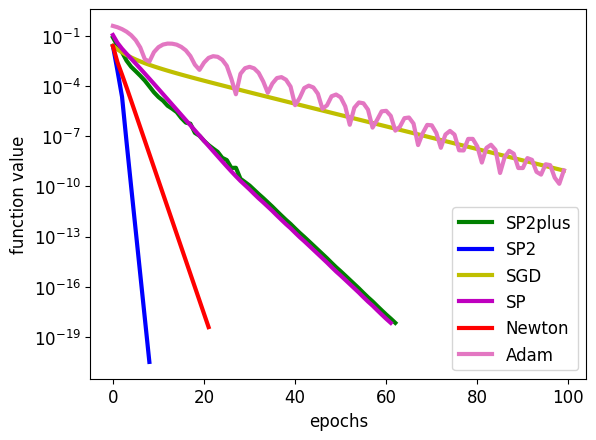

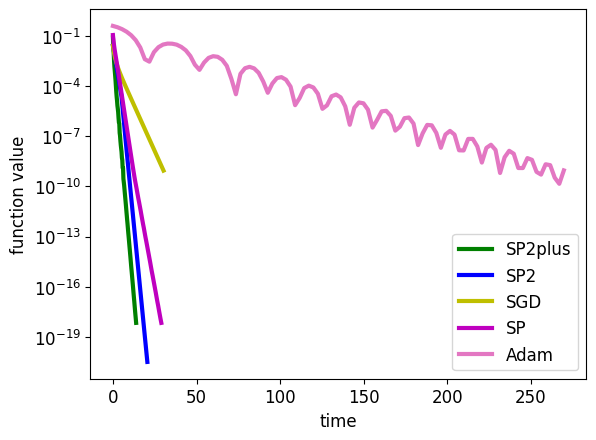

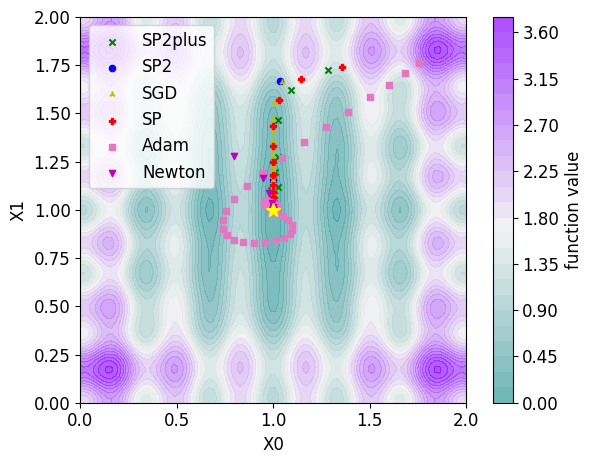

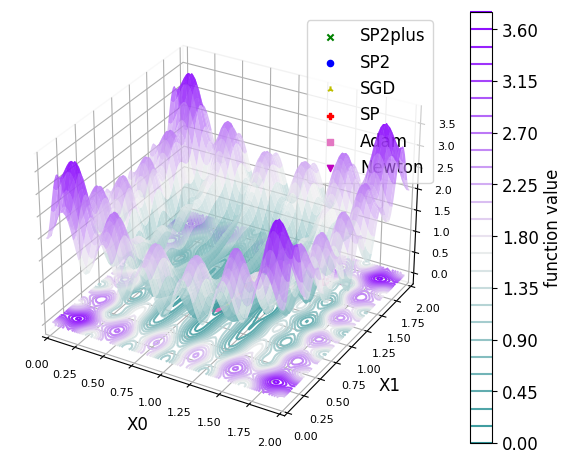

In [8]:
d=2
epochs = 100
x0 = torch.ones(d, requires_grad=True).double() *1.8
fi = LevyN13_i
ffull  = bench.function.LevyN13(d)
run_plot_all(fi,ffull, epochs, stepsize,x0,d)


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

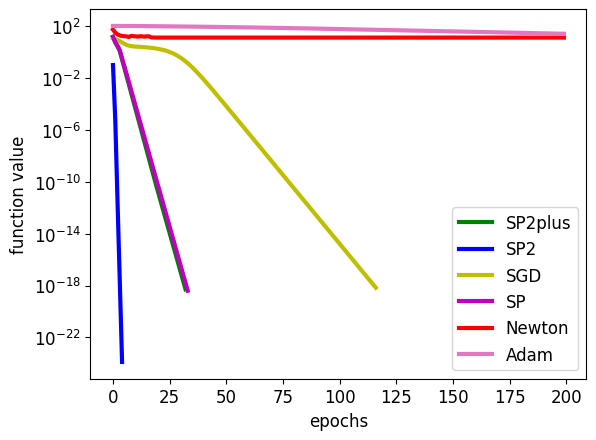

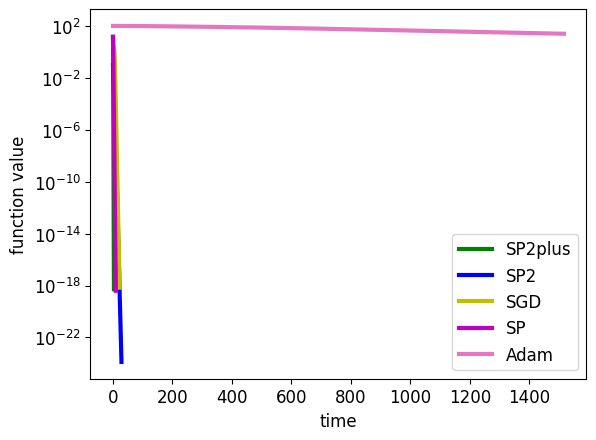

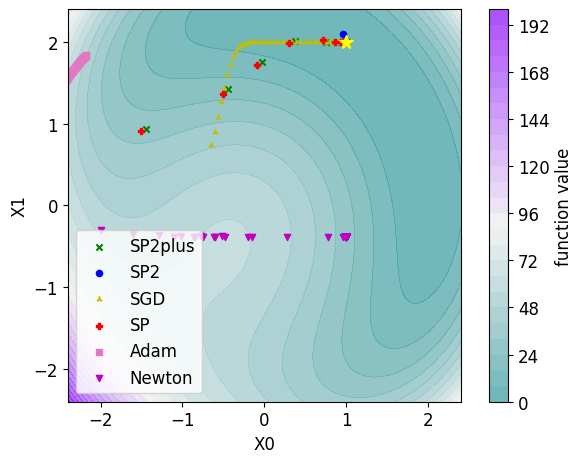

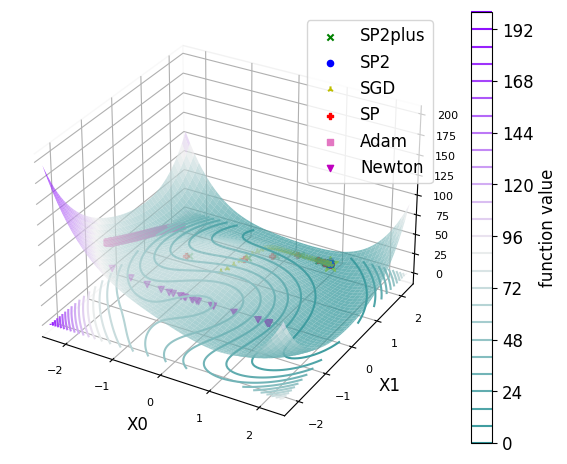

In [9]:
d=2
epochs = 200
x0 = -2*torch.randn(d, requires_grad=True).double()
fi = PermDBeta_i
ffull  = bench.function.PermDBeta(d)
run_plot_all(fi,ffull, epochs, stepsize,x0,d, sgd_step = 0.01)


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

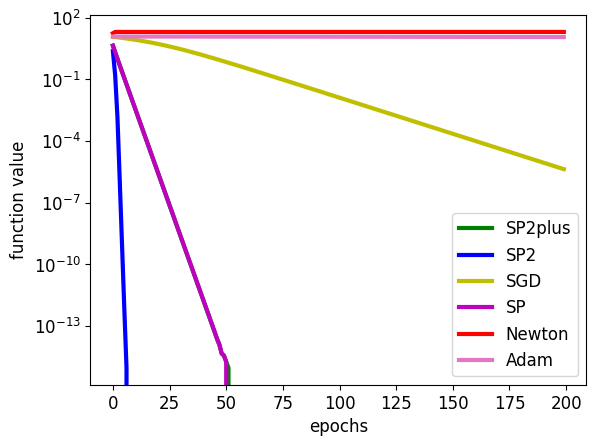

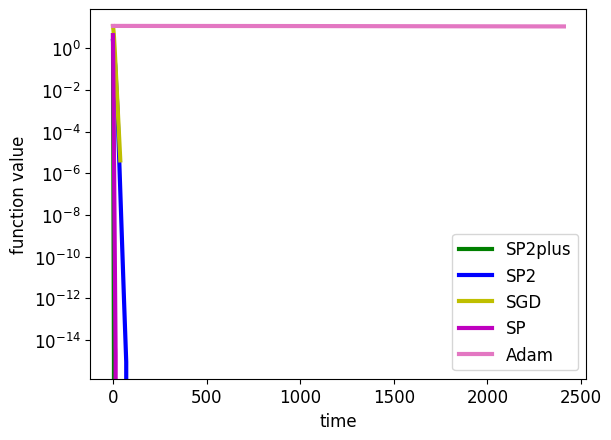

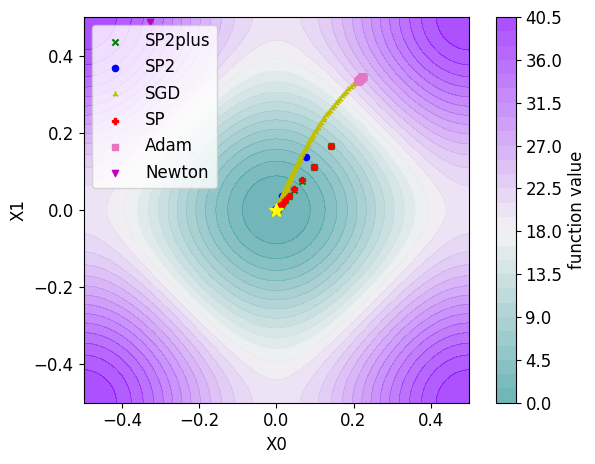

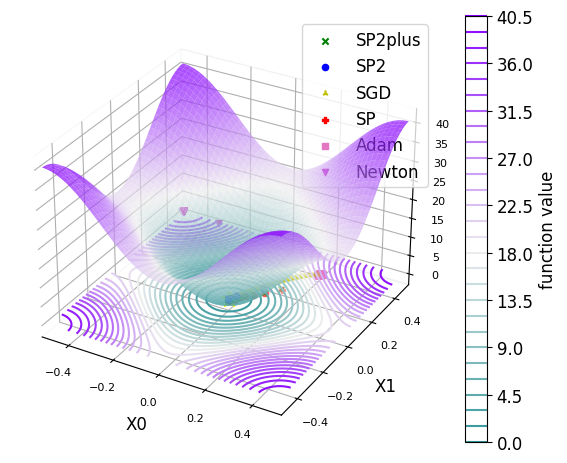

In [10]:
d=2
epochs = 200
x0 = torch.rand(d, requires_grad=True).double() *0.45
fi = Rastrigin_i
ffull  = bench.function.Rastrigin(d)
run_plot_all(fi,ffull, epochs, stepsize,x0,d, sgd_step = 0.0001)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

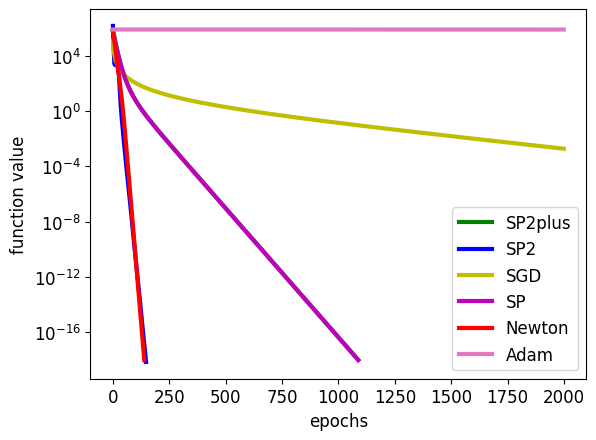

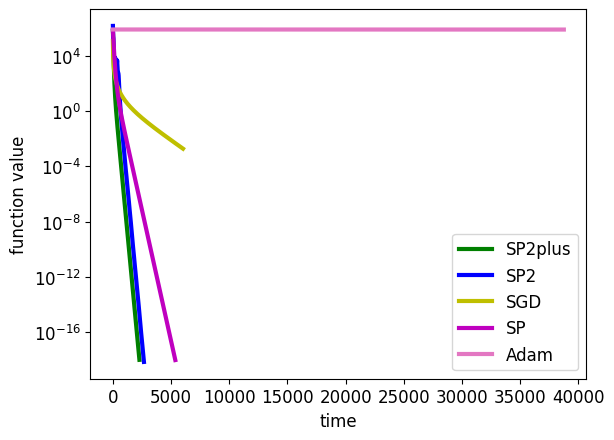

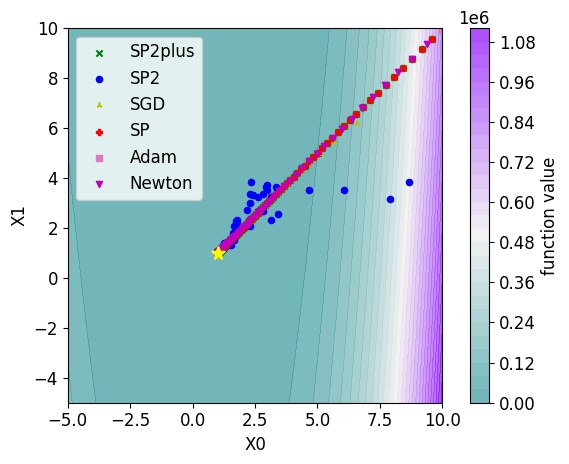

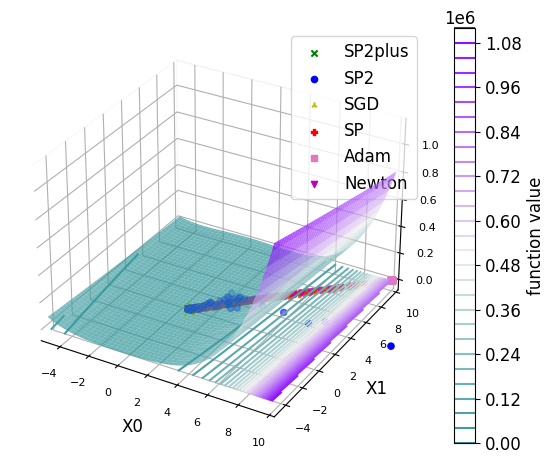

In [11]:
d=2
epochs = 2000
x0 = torch.ones(d, requires_grad=True).double()*10
fi = RosenBrock_i
ffull  = bench.function.Rosenbrock(d)
rosenstep = stepsize/3
run_plot_all(fi,ffull, epochs, rosenstep, x0,d, sgd_step = 0.00001)


In [12]:

def run_all_d_dim(epochs, stepsize, d, sgd_step = None):
    if sgd_step is None:
        sgd_step = stepsize

    x0 = -2*torch.randn(d, requires_grad=True).double()
    fi = PermDBeta_i
    ffull  = bench.function.PermDBeta(d)
    fvals, times, xvals = run_all_method(fi,ffull, epochs, stepsize,x0,d, sgd_step = sgd_step)
    plot_function_values(ffull, fvals, times = times, add_caption = str(d))

    x0 = torch.rand(d, requires_grad=True).double() *0.45
    fi = Rastrigin_i
    ffull  = bench.function.Rastrigin(d)
    fvals, times, xvals = run_all_method(fi,ffull, epochs, stepsize,x0,d, sgd_step = sgd_step)
    plot_function_values(ffull, fvals, times = times, add_caption = str(d))

    x0 = torch.ones(d, requires_grad=True).double()*10
    fi = RosenBrock_i
    ffull  = bench.function.Rosenbrock(d)
    fvals, times, xvals = run_all_method(fi,ffull, epochs, stepsize,x0,d, sgd_step = sgd_step)
    plot_function_values(ffull, fvals, times = times, add_caption = str(d))
    

In [13]:
epochs = 100
# stepsize = 0.1 # for d= 10
stepsize = 0.05 # for d= 100
# run_all_d_dim(epochs, stepsize, d =100, sgd_step = 0.01)